# XGBoost Grid Search with scale_pos_weight Parameter
As we concluded before, for PTB data, we apply the following preprocessing:   
resample: None   
rescaling: StandardScaler   

If you don't have the original files: run the notebook `preprocessing_ptb_default.ipynb`   
Input file:(The preprocessed data)   
ptb_train_clean_default.csv   
ptb_test_clean_default.csv   

Output: Decision Tree model trained  
model_ptb_XGBoost.pkl  

In [1]:
import sys
import os 

data_path = ''
model_output_path = ''
# check if the enviorment is Google Colab 

if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q

    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    model_output_path = data_path

else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/processed/'
    model_output_path = '../models/'

   

Running on local environment
Current working directory: /Users/pingyuan/Documents/codeself/heartbeat-analysis-ai/notebooks


# Read Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RawFiles = dict({
    'test': data_path + 'ptb_test_clean_default.csv',
    'train': data_path + 'ptb_train_clean_default.csv',
})

OutputFiles = dict({
    'model': model_output_path +  'model_ptb_XGBoost.pkl'
})


train = pd.read_csv(RawFiles.get('train'),sep=',',header=0)

test = pd.read_csv(RawFiles.get('test'),sep=',',header=0)

y_train = train['target']
X_train = train.drop('target', axis=1)

y_test = test['target']
X_test = test.drop('target', axis=1)



In [3]:
# Define the XGBoost model with initial parameters
xgb = XGBClassifier()

# Define the grid search parameters for XGBoost
grid_params = {
    'xgb__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'xgb__max_depth': [3, 4, 5],  # Maximum depth of the tree
    'xgb__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'xgb__subsample': [0.8, 1],  # Subsample ratio of the training instances
    'xgb__colsample_bytree': [0.8, 1],  # Subsample ratio of columns when constructing each tree
    'xgb__scale_pos_weight': [1, 10, 50]  # Scale weight for positive class (class balancing)
}

# Define a pipeline that includes scaling and XGBoost
pipeline = Pipeline([
    ('xgb', xgb)  # Apply XGBoost
])

# Define the inner cross-validation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the outer cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the grid search with nested cross-validation
nested_grid_search = GridSearchCV(pipeline, grid_params, cv=inner_cv, scoring='f1', n_jobs=-1)

# Perform nested cross-validation
nested_scores = []
for train_index, test_index in outer_cv.split(X_train):
    X_train_inner, X_test_inner = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_inner, y_test_inner = y_train.iloc[train_index], y_train.iloc[test_index]

    # Fit grid search on the inner cross-validation set
    nested_grid_search.fit(X_train_inner, y_train_inner)
    
    # Get the best model from the inner grid search
    best_model = nested_grid_search.best_estimator_
    
    # Evaluate the model on the outer test set
    y_pred = best_model.predict(X_test_inner)
    
    # Calculate the F1 score
    f1 = f1_score(y_test_inner, y_pred)
    nested_scores.append(f1)


Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 1}
Average F1 Score from Nested Cross-Validation: 0.9852902512430015
F1 score: 0.9829940119760479


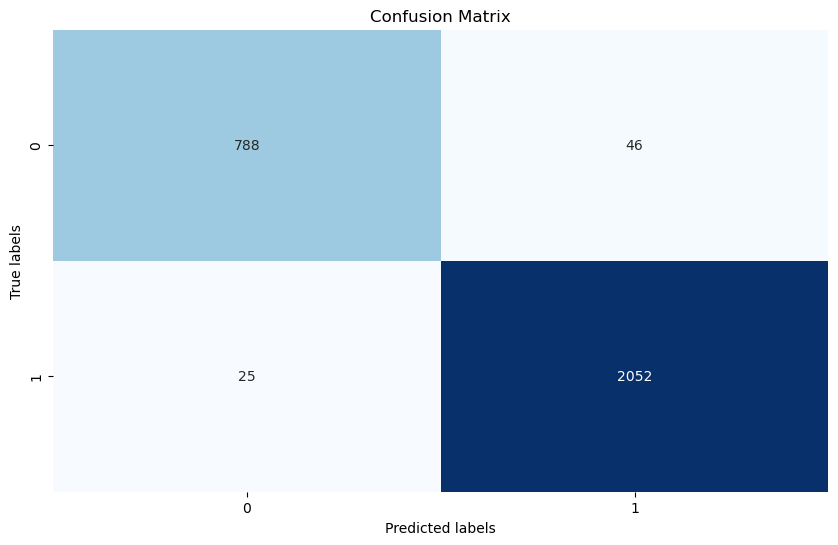

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       834
           1       0.98      0.99      0.98      2077

    accuracy                           0.98      2911
   macro avg       0.97      0.97      0.97      2911
weighted avg       0.98      0.98      0.98      2911



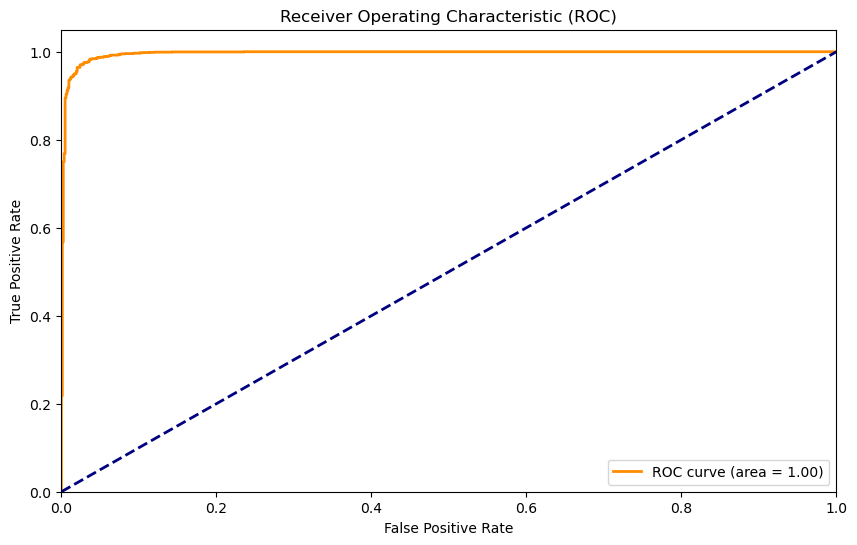

In [4]:

# Print the best hyperparameters
best_params = nested_grid_search.best_params_
print("Best parameters:", best_params)

# Print the average F1 score from the nested cross-validation
print(f'Average F1 Score from Nested Cross-Validation: {np.mean(nested_scores)}')

# Train the final model on the entire dataset
final_model = nested_grid_search.best_estimator_
final_model.fit(X_train, y_train)

# Predict on the test set
y_pred = final_model.predict(X_test)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

# Define the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Define the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Define the ROC curve
if len(np.unique(y_test)) == 2:  # Ensure binary classification
    y_prob = final_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)

    # Calculate the AUC score
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve is only applicable for binary classification.")


In [6]:
# Best the results from model
best_params = {
    'xgb__colsample_bytree': 0.8, # Subsample ratio of columns when constructing each tree
    'xgb__learning_rate': 0.2, # Learning rate
    'xgb__max_depth': 5, # Maximum depth of the tree
    'xgb__n_estimators': 300, # Number of trees in the forest
    'xgb__scale_pos_weight': 1, # Scale weight for positive class. 1 is the default value. 
    'xgb__subsample': 1 # Subsample ratio of the training instances
}

# Print the summary
print("The best performing models are the XGBoost models with and without scale_pos_weight. Both have the following hyperparameters:")
print(f"Best parameters: {best_params}")
print(f"F1 score on the test set: {f1}")

The best performing models are the XGBoost models with and without scale_pos_weight. Both have the following hyperparameters:
Best parameters: {'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 1}
F1 score on the test set: 0.9829940119760479


# Save XGBoost Model

In [7]:
# Save model 
import pickle
# Save the model to a file
with open(OutputFiles.get('model'), 'wb') as model_file:
    pickle.dump(final_model, model_file)